In [1]:
import os, sys
sys.path.append("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
import math, json
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch

from musubi_tuner.dataset.image_video_dataset import resize_image_to_bucket
from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import encode_prompt_conds, vae_encode, vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.frame_pack.utils import crop_or_pad_yield_mask
from musubi_tuner.wan_generate_video import merge_lora_weights
from preproc_utils import get_text_preproc, getres, preproc_image, preproc_mask, prepare_image_inputs, prepare_control_inputs
from attn_utils import get_pltplot_as_pil, get_text_inds_from_dict, get_attn_map

sys.path.append("/home/yo564250/workspace/whisperer/utils")
from img_utils import convert_from_qwen2vl_format
from vistory_utils import StoryDataset

device = torch.device('cuda')
lt.monkey_patch()

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is not installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention


In [2]:
dit_path = "/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors"
vae_path = "/home/yo564250/workspace/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "/home/yo564250/workspace/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "/home/yo564250/workspace/ComfyUI/models/text_encoders/clip_l.safetensors"
image_encoder_path = "/home/yo564250/workspace/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"
lora_path = "/home/yo564250/workspace/ComfyUI/models/Lora/framepack/bg_lora_1000.safetensors"
# lora_path = "/data/whisperer/related/framepackbase/musubi-tuner/outputs/training/s2vnexus_posecontrol_lora/lora_test3.safetensors"

model = load_packed_model(device, dit_path, 'sageattn', device)
model.to(device)
model.eval().requires_grad_(False)

merge_lora_weights(lora_framepack, model, 
    SimpleNamespace(
        lora_weight = [lora_path], lora_multiplier = [1.0], 
        include_patterns=None, exclude_patterns=None, lycoris=None,
        save_merged_model=False
    ), 
device, None)
target_index = [1]
control_indices = [0,10]

vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=text_encoder1_path), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=text_encoder2_path))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=image_encoder_path))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=<All keys matched successfully>
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /home/yo564250/workspace/ComfyUI/models/Lora/framepack/bg_lora_1000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE model (884-16c-hy) from: /home/yo564250/workspace/ComfyUI/models/vae/

In [3]:
prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
height, width = 480, 480

control_image_paths = ["../../docs/bg_sample.png", "../../docs/fg_sample.jpg"]
control_image_mask_paths = ["", ""]

image_paths = ["../../docs/bg_sample.png"]
entity_prompts = ["An anime-style girl wearing a school uniform and ribbon tie"]
entity_mask_paths = ["../../docs/bg_sample_mask.png", '../../docs/bg_sample_mask_inverted.png']

In [4]:
text_kwargs = get_text_preproc(prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, entity_prompts=entity_prompts, device=device)

image_kwargs, img_np = prepare_image_inputs(
    image_paths, feature_extractor, image_encoder, 
    width=width, height=height, 
    target_index=target_index, device=device, dtype=torch.bfloat16)

# control_image_paths[0] = Image.open(control_image_paths[0]).resize((width, height))

control_kwargs, control_nps = prepare_control_inputs(
    control_image_paths, control_image_mask_paths, vae,
    # width=None, height=None, 
    width=width, height=height,
    control_indices=control_indices)

entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entity_mask_paths], 1)

  0%|          | 0/25 [00:00<?, ?it/s]

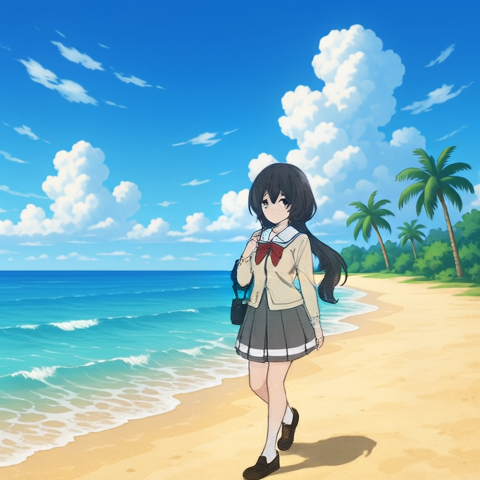

In [5]:
num_inference_steps=25
# seed = np.random.randint(2**31)
seed = 1816186073
# seed = 2105350387 1989424941 1816186073
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=num_inference_steps,
    generator=generator, device=device, dtype=torch.bfloat16,
    cache_results=False, 
    # cache_layers = ['transformer_blocks.2', 'transformer_blocks.8', 'transformer_blocks.14'], 
    clean_latent_bbox=None,
    # use_attention_masking=["no_cross_control_latents", "mask_control"],
    # entity_masks=entity_masks,
    **text_kwargs, 
    **image_kwargs,
    **control_kwargs
)
history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)
result_img = np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)

# Image.fromarray(np.concatenate(control_nps + [result_img], axis=1))
Image.fromarray(result_img)

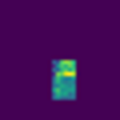

In [34]:
timesteps = sorted(list(attn_cache['transformer_blocks.14'].keys()), reverse=False)
token_H, token_W = height // 16, width // 16
token_C = len(control_indices + target_index)
hidden_size = token_H * token_W * token_C

with torch.inference_mode():
    attention_map = []
    for t in range(0,25,5):
        attention_prob = attn_cache['transformer_blocks.14'][timesteps[t]]
        attention_prob = attention_prob[:,:,:hidden_size,:].to(device)
        attention_map.append(attention_prob)
    attention_map = torch.stack(attention_map, dim=0).mean(dim=0)
    attention_map = rearrange(attention_map, 'B A (C H W) D -> B A C H W D', H=token_H, W=token_W)
    attention_map = attention_map[:,:,-1,:,:,:].sum(1).squeeze(1).permute(0,3,1,2) #B, D, H, W

attn_inds = list(range(900,1800))
# get_text_inds_from_dict('girl', text_kwargs['prompt_strtokens'])
# attn_inds = [hidden_size+729+3, hidden_size+729+24]
attention_data = attention_map[0,attn_inds,:,:].mean(axis=0).to(dtype=torch.float32).cpu().numpy()
attention_image = get_pltplot_as_pil(attention_data)
attention_image.resize((120,120))

torch.Size([1, 3462, 30, 30])


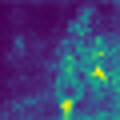

In [37]:
attn_images = get_attn_map(
    {k:v for k,v in attn_cache.items() if k.startswith("transformer_blocks")}, 
    [3,24], 
    block_id=f'transformer_blocks.2', 
    token_type = 'text',
    height=height, width=width, token_C=len(control_indices + target_index),
    embed_size = 729,
    t_0=0, t_1=25)
attn_images.resize((120,120))

In [ ]:
# width, height = None, None
# control_latents, control_nps = [], []
# for i, (control_image_path, control_mask_path) in enumerate(zip(control_image_paths, control_image_mask_paths)):
#     c_img_tensor, c_img_np = preproc_image(control_image_path, width, height)
#     print(c_img_tensor)
#     c_H, c_W = c_img_tensor.shape[-2:]
#     c_img_latent = vae_encode(c_img_tensor, vae).cpu()
#     print(c_img_latent)
#     c_mask_image, c_mask_np = preproc_mask(control_mask_path, c_W, c_H)
#     print(c_mask_image)
#     c_img_latent = c_img_latent * c_mask_image
#     control_latents.append(c_img_latent)
#     control_nps.append(np.concatenate([c_img_np, resize_image_to_bucket(c_mask_np, (c_W, c_H))[..., None]], -1))
# # clean_latents = torch.cat(control_latents, dim=2)  # (1, 16, num_control_images, H//8, W//8)
# clean_latents = control_latents
# clean_latent_indices = [torch.tensor([[ind]], dtype=torch.int64) for ind in control_indices]

defaultdict(<class 'list'>, {'clean_latents': [(0, 900), (900, 1800)], 'noise': [(1800, 2700)], 'image_embeddings': [(2700, 3429)], 'text_embeddings': [(3429, 3450), (3450, 3462)]})


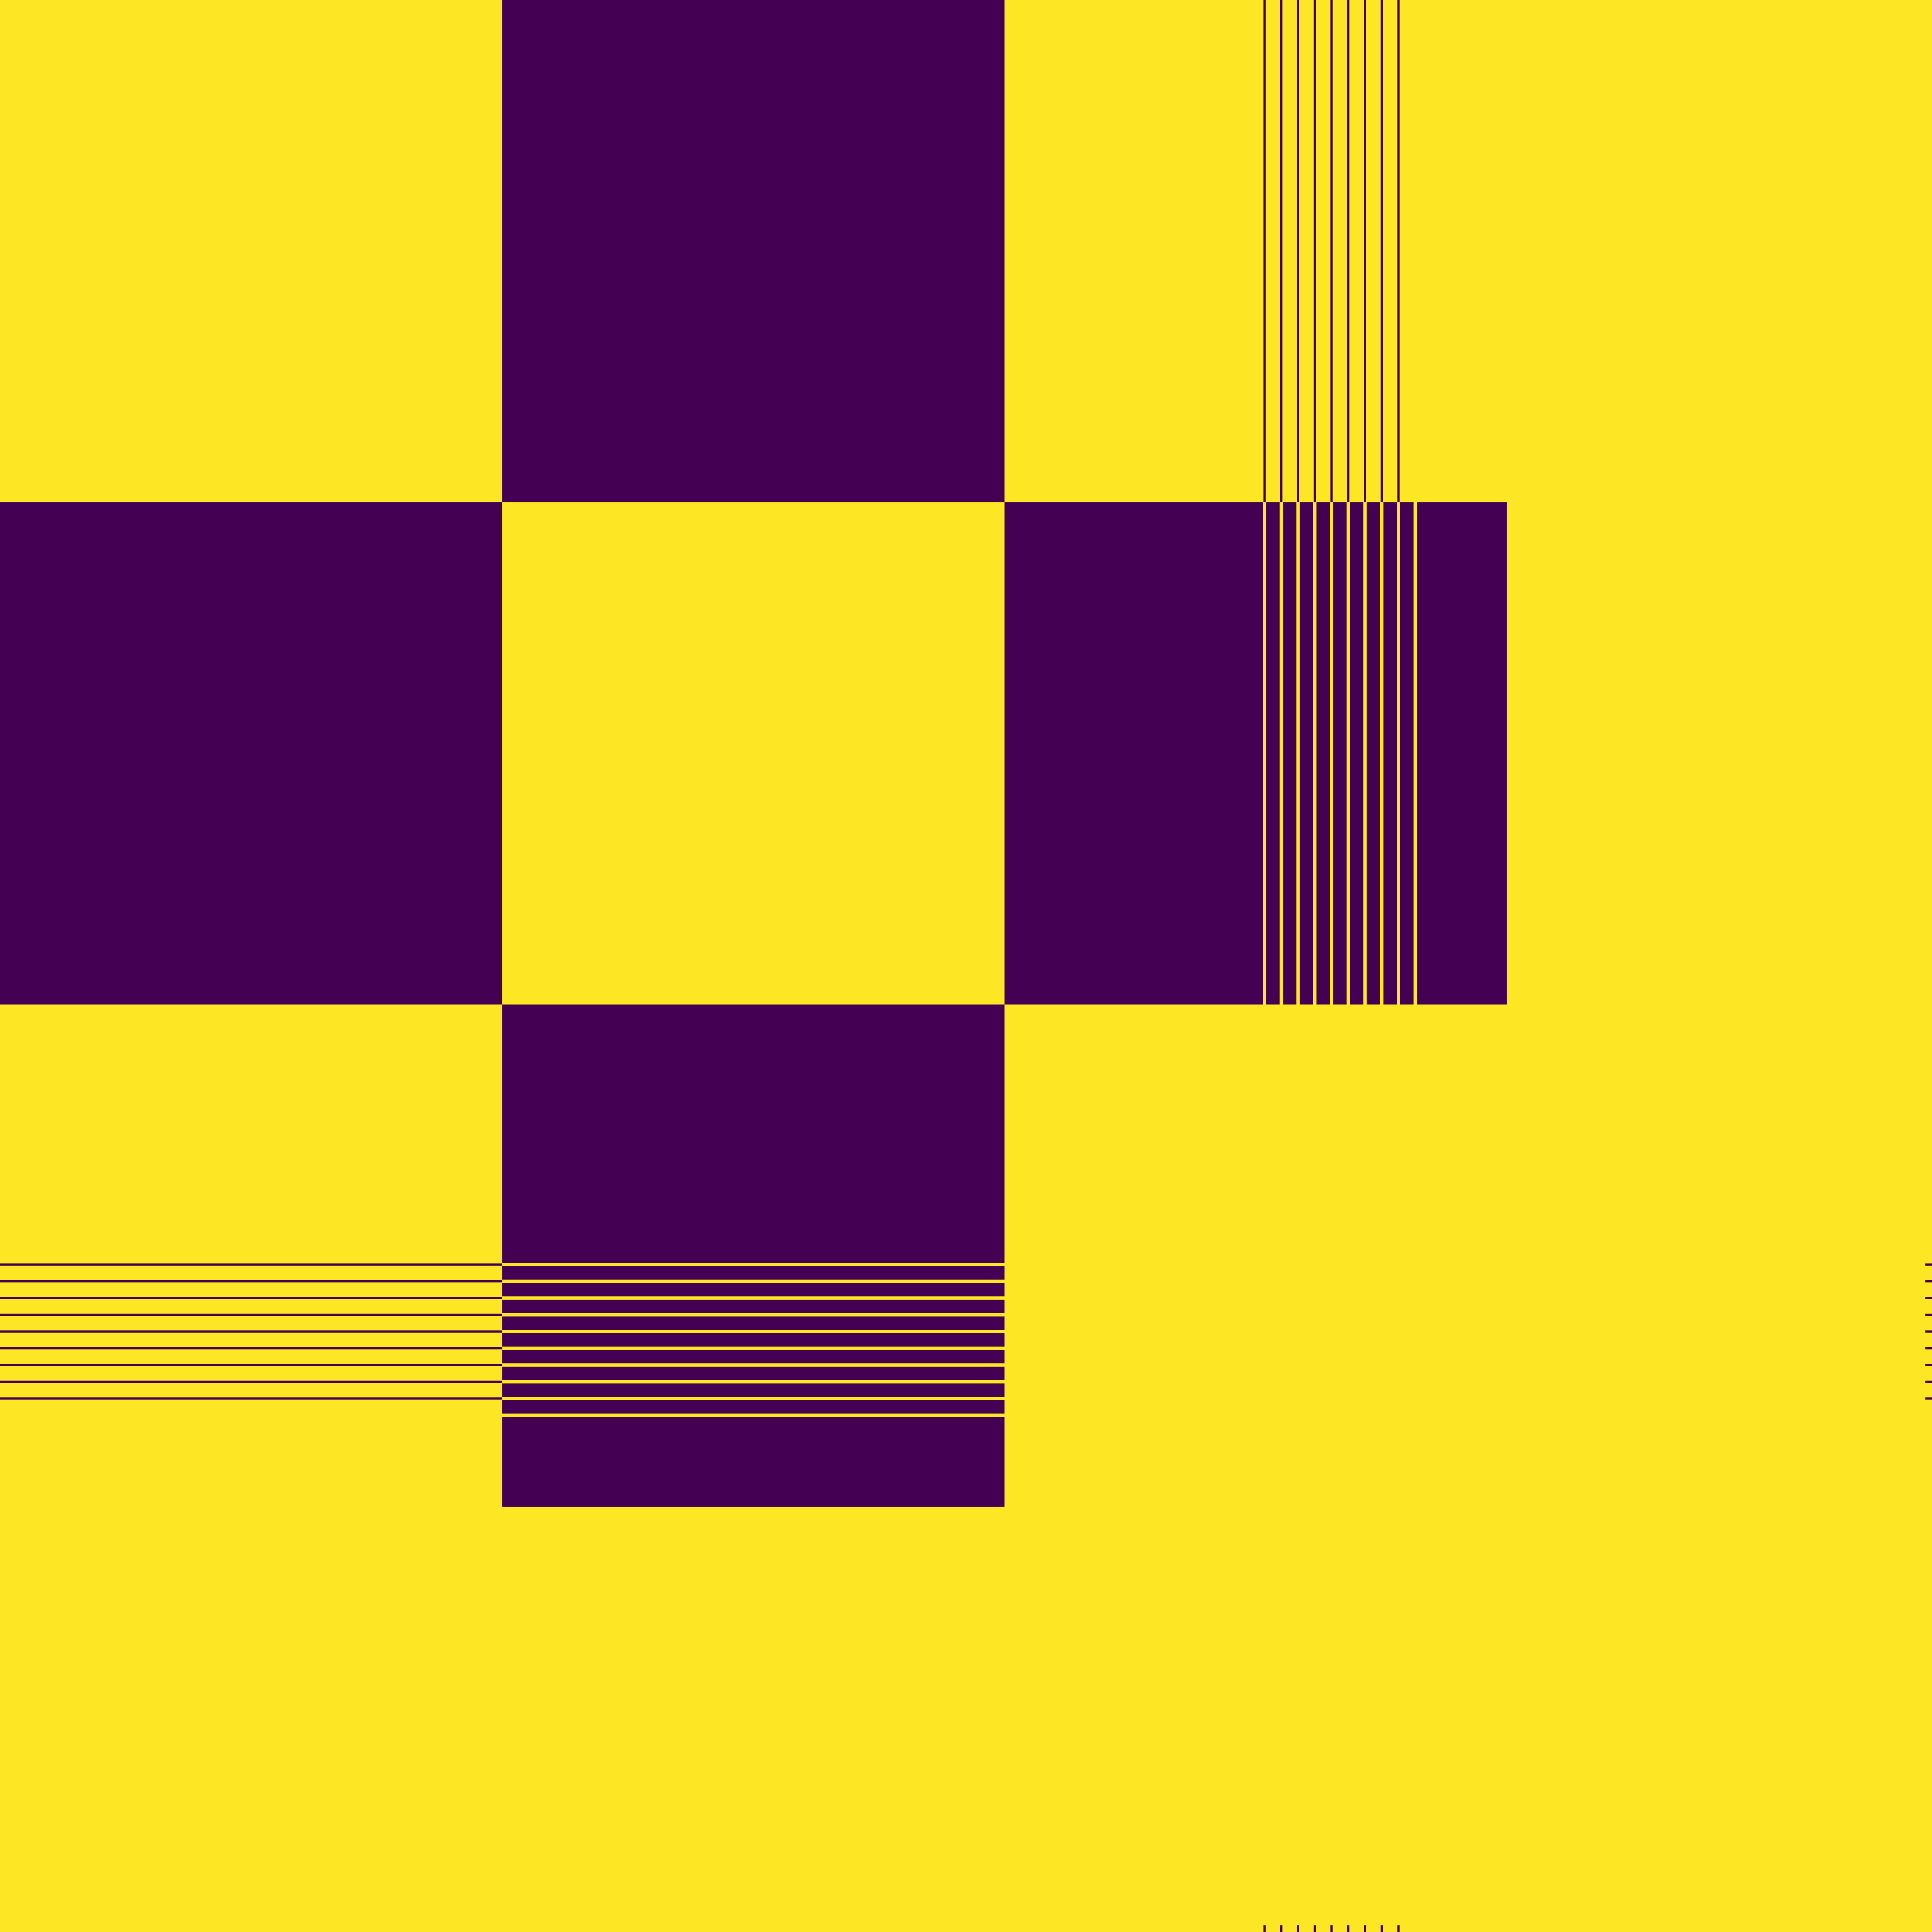

In [11]:
print(attn_cache['attn_dict'])
attn_mask = attn_cache['attn_mask'].clone().to(dtype=torch.float32)
get_pltplot_as_pil(attn_mask.cpu().numpy()[0], vmin=-9999., vmax=0.)